<a href="https://colab.research.google.com/github/aalvinsu/Alvin-Public/blob/main/GA4_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pada analisis kali ini kita akan membahas bagaimana customer behavior pada Google Merchendise Store https://shop.googlemerchandisestore.com/ (dataset: bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_) dan bagaimana mereka berinteraksi pada official Google online shop tersebut.

Berikut adalah beberapa pertanyaan yang akan terjawab mengenai behavior mereka selama kurun waktu 3 bulan (2020-11-01 to 2021-01-31)

Dengan kita membaca penelitian ini, kita akan memahami objektif dari riset ini, yaitu:

1. Overall top global income dari Google Merchandise Store.
2. Customer Behavior
3. Customer Journey

## Import Data

In [57]:
from google.colab import auth
from google.cloud import bigquery
import matplotlib.pyplot as plt
# Autentikasi akun Google
auth.authenticate_user()

# Membuat klien BigQuery
client = bigquery.Client(project='iconic-elevator-196204')

## Eksplorasi Data

### Mengetahui jumlah event pada website

In [58]:
# Mengetahui jumlah event pada website
query = '''
SELECT
  COUNT(*) AS event_count,
  COUNT(DISTINCT user_pseudo_id) AS user_count,
  COUNT(DISTINCT event_date) AS day_count
FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
'''

# Menjalankan query menggunakan klien BigQuery
query_job = client.query(query)

# Mendapatkan hasil query
results = query_job.result()

# Menampilkan hasil
for row in results:
  print(f"Event Count: {row.event_count}")
  print(f"User Count: {row.user_count}")
  print(f"Day Count: {row.day_count}")

Event Count: 4295584
User Count: 270154
Day Count: 92


## Menganalisis Revenue dari ecommerce

### Mengetahui 3 negara pembeli terbanyak

In [60]:
# Mengetahui 3 negara pembeli terbanyak
query = """
SELECT
    geo.country AS country,
    SUM(ecommerce.purchase_revenue) AS revenue
FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
WHERE
    _TABLE_SUFFIX BETWEEN '20201101' AND '20210131'
    AND event_name = 'purchase'
    AND geo.country IS NOT NULL
GROUP BY
    country
ORDER BY
    revenue DESC
LIMIT
    3
"""

# Menjalankan query menggunakan klien BigQuery
query_job = client.query(query)

# Mendapatkan hasil query
results = query_job.result()

# Menampilkan hasil
for row in results:
    print(f"Country: {row.country}")
    print(f"Revenue: {row.revenue}")
    print("---")

Country: United States
Revenue: 160573.0
---
Country: India
Revenue: 34986.0
---
Country: Canada
Revenue: 32799.0
---


Karena US adalah negara dengan penyumbang revenue terbanyak pada ecommerce milik Google, kita bisa melakukan analisis lebih dalam mengenai grafik bulanan dari revenue yang diberikan oleh konsumen yang berasal dari US

## Mencari Tahu Berapa Jumlah Revenue dari US

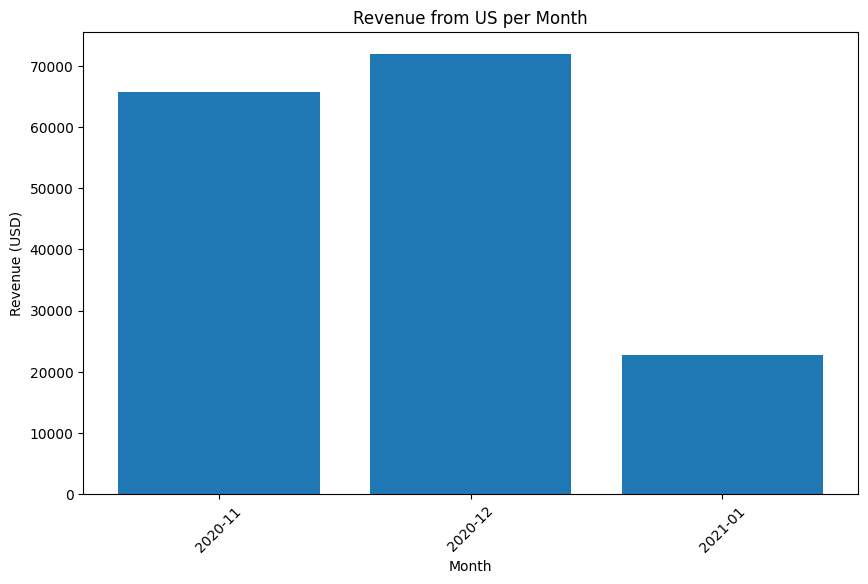

In [61]:
# Menjalankan query SQL
query = """
SELECT
  FORMAT_TIMESTAMP('%Y-%m', PARSE_TIMESTAMP('%Y%m%d', _TABLE_SUFFIX)) AS month,
  SUM(ecommerce.purchase_revenue) AS revenue
FROM
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
WHERE
  geo.country = 'United States'
  AND _TABLE_SUFFIX BETWEEN '20201101' AND '20210131'
  AND ecommerce.purchase_revenue IS NOT NULL
GROUP BY
  month
ORDER BY
  month
"""

# Menjalankan query menggunakan klien BigQuery
query_job = client.query(query)

# Mendapatkan hasil query
results = query_job.result()

# Membuat list bulan dan pendapatan
months = []
revenues = []
for row in results:
    months.append(row.month)
    revenues.append(row.revenue)

# Membuat plot
plt.figure(figsize=(10, 6))
plt.bar(months, revenues)
plt.xlabel('Month')
plt.ylabel('Revenue (USD)')
plt.title('Revenue from US per Month')
plt.xticks(rotation=45)
plt.show()

## Customer Behaviour Analisis

### Mengetahui Rata-rata jumlah produk yang terjual kepada setiap usernya

In [63]:
# Mengetahui Rata-rata jumlah produk yang terjual kepada setiap usernya
query = '''
SELECT
  COUNT(*) / COUNT(DISTINCT user_pseudo_id) AS avg_transaction_per_purchaser
FROM
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
WHERE
  event_name IN ('in_app_purchase', 'purchase')
  AND _TABLE_SUFFIX BETWEEN '20201201' AND '20210131'
'''

# Menjalankan query menggunakan klien BigQuery
query_job = client.query(query)

# Mendapatkan hasil query
results = query_job.result()

# Menampilkan hasil
for row in results:
  print(f"Avg Transaction per Purchaser: {row.avg_transaction_per_purchaser}")

Avg Transaction per Purchaser: 1.2138805472138805


Rata-Rata jumlah pageview terhadap jumlah pembelian

In [64]:
# Rata-Rata jumlah pageview terhadap jumlah pembelian
query = """
WITH
  UserInfo AS (
    SELECT
      user_pseudo_id,
      COUNTIF(event_name = 'page_view') AS page_view_count,
      COUNTIF(event_name IN ('in_app_purchase', 'purchase')) AS purchase_event_count
    FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
    WHERE _TABLE_SUFFIX BETWEEN '20201201' AND '20201202'
    GROUP BY 1
  )
SELECT
  (purchase_event_count > 0) AS purchaser,
  COUNT(*) AS user_count,
  SUM(page_view_count) AS total_page_views,
  SUM(page_view_count) / COUNT(*) AS avg_page_views
FROM UserInfo
GROUP BY 1
"""

# Menjalankan query menggunakan klien BigQuery
query_job = client.query(query)

# Mendapatkan hasil query
results = query_job.result()

# Menampilkan hasil
for row in results:
    print(f"Purchaser: {row.purchaser}")
    print(f"User Count: {row.user_count}")
    print(f"Total Page Views: {row.total_page_views}")
    print(f"Avg Page Views: {row.avg_page_views}")
    print("---")

Purchaser: False
User Count: 7916
Total Page Views: 34786
Avg Page Views: 4.394391106619505
---
Purchaser: True
User Count: 172
Total Page Views: 6591
Avg Page Views: 38.31976744186046
---


### Menghitung pengeluaran 10 user per session by user terbanyak

In [74]:
# Menghitung pengeluaran 10 user per session by user terbanyak
query = """
SELECT
  user_pseudo_id,
  COUNT(DISTINCT(SELECT EP.value.int_value FROM UNNEST(event_params) AS EP WHERE key = 'ga_session_id')) AS session_count,
  AVG(
    (
      SELECT COALESCE(EP.value.int_value, EP.value.float_value, EP.value.double_value)
      FROM UNNEST(event_params) AS EP
      WHERE key = 'value'
    )) AS avg_spend_per_session_by_user
FROM
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
WHERE
  event_name = 'purchase'
  AND _TABLE_SUFFIX BETWEEN '20201101' AND '20210131'
GROUP BY
  user_pseudo_id
ORDER BY
  avg_spend_per_session_by_user DESC
LIMIT
  10
"""

# Menjalankan query menggunakan klien BigQuery
query_job = client.query(query)

# Mendapatkan hasil query
results = query_job.result()

# Menampilkan hasil
for row in results:
    print(f"User Pseudo ID: {row.user_pseudo_id}")
    print(f"Session Count: {row.session_count}")
    print(f"Avg Spend per Session by User: {row.avg_spend_per_session_by_user}")
    print("---")

User Pseudo ID: 81036435.1157569602
Session Count: 1
Avg Spend per Session by User: 1530.4
---
User Pseudo ID: 7134559299.4601048201
Session Count: 1
Avg Spend per Session by User: 1200.0
---
User Pseudo ID: 12306432.7939489449
Session Count: 1
Avg Spend per Session by User: 1170.0
---
User Pseudo ID: 51248671.8133898155
Session Count: 1
Avg Spend per Session by User: 997.5
---
User Pseudo ID: 2566418.5535518831
Session Count: 1
Avg Spend per Session by User: 864.8
---
User Pseudo ID: 39388951.3688006674
Session Count: 1
Avg Spend per Session by User: 805.6
---
User Pseudo ID: 2278219.0388083386
Session Count: 1
Avg Spend per Session by User: 784.32
---
User Pseudo ID: 1033085.6917088117
Session Count: 1
Avg Spend per Session by User: 711.84
---
User Pseudo ID: 1532927.6404323781
Session Count: 1
Avg Spend per Session by User: 683.24
---
User Pseudo ID: 6822684.1627482502
Session Count: 1
Avg Spend per Session by User: 671.2
---


Mengetahui Customer Journey

### Mengetahui channel marketing yang paling banyak mendatangkan pengunjung

Campaign Session: (direct)
Sessions: 122745
---
Campaign Session: (referral)
Sessions: 122672
---
Campaign Session: (organic)
Sessions: 73471
---
Campaign Session: <Other>
Sessions: 34508
---
Campaign Session: (data deleted)
Sessions: 5051
---
Campaign Session: Data Share Promo
Sessions: 1484
---
Campaign Session: NewYear_V1
Sessions: 68
---
Campaign Session: NewYear_V2
Sessions: 39
---
Campaign Session: Holiday_V2
Sessions: 38
---
Campaign Session: BlackFriday_V2
Sessions: 25
---
Campaign Session: Holiday_V1
Sessions: 19
---
Campaign Session: BlackFriday_V1
Sessions: 9
---


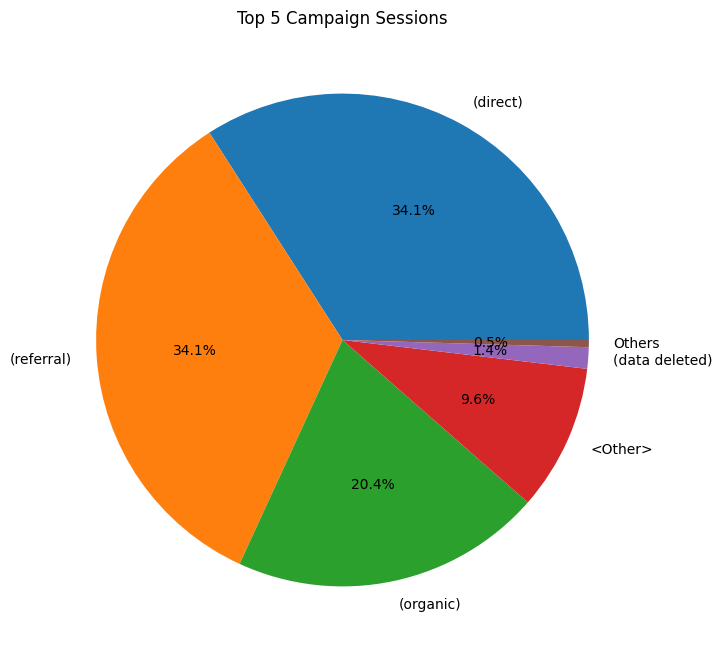

In [78]:
# Query
query = """
WITH prep AS (
  SELECT
    user_pseudo_id,
    (SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'ga_session_id') AS session_id,
    MAX((SELECT value.string_value FROM UNNEST(event_params) WHERE key = 'campaign')) AS campaign
  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20201101' AND '20210131'
  GROUP BY
    user_pseudo_id,
    session_id
)
SELECT
  COALESCE(campaign, '(direct)') AS campaign_session,
  COUNT(DISTINCT CONCAT(user_pseudo_id, session_id)) AS sessions
FROM
  prep
GROUP BY
  campaign_session
ORDER BY
  sessions DESC;
"""

# Jalankan query
query_job = client.query(query)

# Dapatkan hasil query
results = query_job.result()

# Tampilkan hasil
for row in results:
    print("Campaign Session:", row.campaign_session)
    print("Sessions:", row.sessions)
    print("---")

# Jalankan query dan simpan hasilnya dalam variabel results
query_job = client.query(query)
results = query_job.result()

# Simpan hasil query dalam daftar
data = [(row.campaign_session, row.sessions) for row in results]

# Urutkan data berdasarkan sessions secara descending
sorted_data = sorted(data, key=lambda x: x[1], reverse=True)

# Ambil 5 data teratas dan sisanya digabungkan menjadi "others"
top_5 = sorted_data[:5]
others = sorted_data[5:]
sessions_top_5 = [d[1] for d in top_5]
sessions_others = sum(d[1] for d in others)

# Label dan nilai untuk top 5 data
labels_top_5 = [d[0] for d in top_5]
labels_top_5.append("Others")
sessions_top_5.append(sessions_others)

# Buat pie chart
plt.figure(figsize=(8, 8))
plt.pie(sessions_top_5, labels=labels_top_5, autopct='%1.1f%%')
plt.title('Top 5 Campaign Sessions')

# Tampilkan pie chart
plt.show()

Medium Session: referral
Sessions: 132249
---
Medium Session: (none)
Sessions: 122728
---
Medium Session: organic
Sessions: 74433
---
Medium Session: <Other>
Sessions: 18756
---
Medium Session: cpc
Sessions: 5710
---
Medium Session: (data deleted)
Sessions: 5155
---
Medium Session: affiliate
Sessions: 1012
---
Medium Session: email
Sessions: 86
---


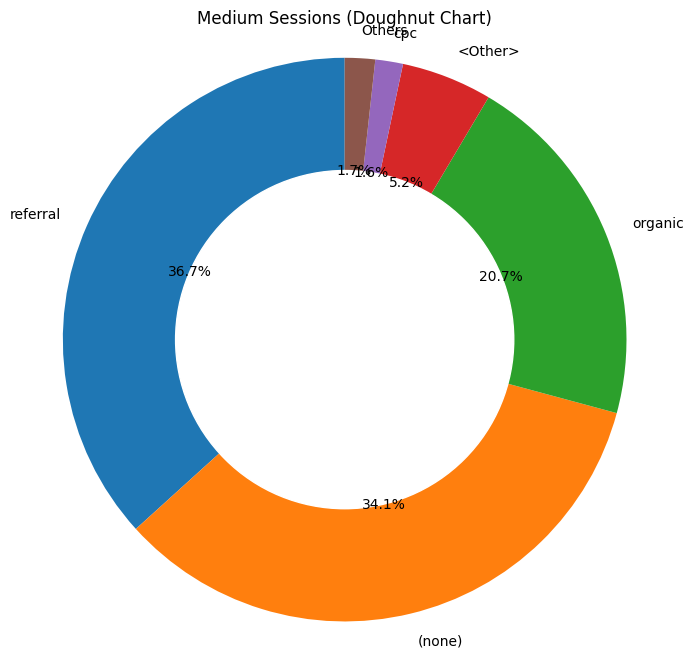

In [80]:
# Query
query = """
WITH prep AS (
  SELECT
    user_pseudo_id,
    (SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'ga_session_id') AS session_id,
    MAX((SELECT value.string_value FROM UNNEST(event_params) WHERE key = 'medium')) AS medium
  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20201101' AND '20210131'
  GROUP BY
    user_pseudo_id,
    session_id
)
SELECT
  COALESCE(medium, '(none)') AS medium_session,
  COUNT(DISTINCT CONCAT(user_pseudo_id, session_id)) AS sessions
FROM
  prep
GROUP BY
  medium_session
ORDER BY
  sessions DESC;
"""

# Jalankan query
query_job = client.query(query)

# Dapatkan hasil query
results = query_job.result()

# Tampilkan hasil
for row in results:
    print("Medium Session:", row.medium_session)
    print("Sessions:", row.sessions)
    print("---")

# Jalankan query dan simpan hasilnya dalam variabel results
query_job = client.query(query)
results = list(query_job.result())  # Ubah menjadi list untuk menghindari kesalahan "Iterator has already started"

# Simpan hasil query dalam daftar
data = [(row.medium_session, row.sessions) for row in results]

# Urutkan data berdasarkan sessions secara descending
sorted_data = sorted(data, key=lambda x: x[1], reverse=True)

# Ambil 5 data teratas dan sisanya digabungkan menjadi "others"
top_5 = sorted_data[:5]
others = sorted_data[5:]
sessions_top_5 = [d[1] for d in top_5]
sessions_others = sum(d[1] for d in others)

# Label dan nilai untuk top 5 data
labels_top_5 = [d[0] for d in top_5]
labels_top_5.append("Others")
sessions_top_5.append(sessions_others)

# Buat doughnut chart
plt.figure(figsize=(8, 8))
plt.pie(sessions_top_5, labels=labels_top_5, autopct='%1.1f%%', startangle=90)
plt.title('Medium Sessions (Doughnut Chart)')

# Lingkaran dalam (doughnut)
circle = plt.Circle((0, 0), 0.6, color='white')
fig = plt.gcf()
fig.gca().add_artist(circle)

# Tampilkan doughnut chart
plt.axis('equal')
plt.show()

## Mengetahui Channel Medium Marketing Yang Tepat Untuk Mengakuisisi User Baru

In [71]:
# Query
query = """
SELECT
    -- user default channel grouping (dimension | the channel group associated with an user's first session)
    CASE
        WHEN traffic_source.source = '(direct)' AND (traffic_source.medium IN ('(not set)', '(none)')) THEN 'Direct'
        WHEN REGEXP_CONTAINS(traffic_source.name, 'cross-network') THEN 'Cross-network'
        WHEN (REGEXP_CONTAINS(traffic_source.source, 'alibaba|amazon|google shopping|shopify|etsy|ebay|stripe|walmart')
            OR REGEXP_CONTAINS(traffic_source.name, '^(.*(([^a-df-z]|^)shop|shopping).*)$'))
            AND REGEXP_CONTAINS(traffic_source.medium, '^(.*cp.*|ppc|paid.*)$') THEN 'Paid Shopping'
        WHEN REGEXP_CONTAINS(traffic_source.source, 'baidu|bing|duckduckgo|ecosia|google|yahoo|yandex')
            AND REGEXP_CONTAINS(traffic_source.medium, '^(.*cp.*|ppc|paid.*)$') THEN 'Paid Search'
        WHEN REGEXP_CONTAINS(traffic_source.source, 'badoo|facebook|fb|instagram|linkedin|pinterest|tiktok|twitter|whatsapp')
            AND REGEXP_CONTAINS(traffic_source.medium, '^(.*cp.*|ppc|paid.*)$') THEN 'Paid Social'
        WHEN REGEXP_CONTAINS(traffic_source.source, 'dailymotion|disneyplus|netflix|youtube|vimeo|twitch|vimeo|youtube')
            AND REGEXP_CONTAINS(traffic_source.medium, '^(.*cp.*|ppc|paid.*)$') THEN 'Paid Video'
        WHEN traffic_source.medium IN ('display', 'banner', 'expandable', 'interstitial', 'cpm') THEN 'Display'
        WHEN REGEXP_CONTAINS(traffic_source.source, 'alibaba|amazon|google shopping|shopify|etsy|ebay|stripe|walmart')
            OR REGEXP_CONTAINS(traffic_source.name, '^(.*(([^a-df-z]|^)shop|shopping).*)$') THEN 'Organic Shopping'
        WHEN REGEXP_CONTAINS(traffic_source.source, 'badoo|facebook|fb|instagram|linkedin|pinterest|tiktok|twitter|whatsapp')
            OR traffic_source.medium IN ('social', 'social-network', 'social-media', 'sm', 'social network', 'social media') THEN 'Organic Social'
        WHEN REGEXP_CONTAINS(traffic_source.source, 'dailymotion|disneyplus|netflix|youtube|vimeo|twitch|vimeo|youtube')
            OR REGEXP_CONTAINS(traffic_source.medium, '^(.*video.*)$') THEN 'Organic Video'
        WHEN REGEXP_CONTAINS(traffic_source.source, 'baidu|bing|duckduckgo|ecosia|google|yahoo|yandex')
            OR traffic_source.medium = 'organic' THEN 'Organic Search'
        WHEN REGEXP_CONTAINS(traffic_source.source, 'email|e-mail|e_mail|e mail')
            OR REGEXP_CONTAINS(traffic_source.medium, 'email|e-mail|e_mail|e mail') THEN 'Email'
        WHEN traffic_source.medium = 'affiliate' THEN 'Affiliates'
        WHEN traffic_source.medium = 'referral' THEN 'Referral'
        WHEN traffic_source.medium = 'audio' THEN 'Audio'
        WHEN traffic_source.medium = 'sms' THEN 'SMS'
        WHEN traffic_source.medium LIKE '%push'
            OR REGEXP_CONTAINS(traffic_source.medium, 'mobile|notification') THEN 'Mobile Push Notifications'
        ELSE 'Unassigned' END AS channel_grouping_user,
    COUNT(DISTINCT user_pseudo_id) AS users
FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
WHERE
    _TABLE_SUFFIX BETWEEN '20201101' AND '20210131'
GROUP BY
    channel_grouping_user
ORDER BY
    users DESC;
"""

# Jalankan query
query_job = client.query(query)

# Dapatkan hasil query
results = query_job.result()

# Tampilkan hasil
for row in results:
    print("Channel Grouping User:", row.channel_grouping_user)
    print("Users:", row.users)
    print("---")

Channel Grouping User: Organic Search
Users: 130848
---
Channel Grouping User: Direct
Users: 75951
---
Channel Grouping User: Unassigned
Users: 65309
---
Channel Grouping User: Referral
Users: 32883
---
Channel Grouping User: Paid Search
Users: 15527
---


Website ini memiliki channel akusisi Organic Search terbanyak yang artinya website ini memiliki user experience yang baik sehingga berhasil membuat search engine memprioritaskan website ini dibandingkan website lainnya. Akan tetapi adanya channel grouping "Unassigned" yang membuat kita harus melakukan penelitian lebih mendalam lagi apakah karena channel grouping yang disetting sudah tepat atau belum.

Kesimpulan dalam riset ini adalah webiste milik Google ini mendapatkan angka akuisis user terbesar melalui channel organik dan juga referral. Tidak hanya itu, website ini berhasil membuat salah satu customer berhasil melakukan pembelanjaan sebesar lebih dari $1,530 dengan jumlah 1 session, yang kemungkinan besar hal ini terjadi karena website ini sudah terpercaya dan juga berhasil membuat customer melakukan transaksi dalam jumlah besar dalam satu waktu.

Setelah melihat dari jumlah transaksi yang terjadi dan channel medium yang berhasil membawa dampak besar adalah channel organik dan referral, membuat kita bisa melakukan optimisasi pada website dengan terus memberikan promo referral (affiliate) maupun membuat website lebih seamless dengan mobile optimization atau bisa mencoba membuat app.